With The bernouli model, I only needed one channel, but if i have categorical data, do i need to use multiple channels?

with continuous data, the outputs can be considered as a probablity of a state, however, with discrete data, I have no measure for the probability of a state. 

I see different ways to model this categorical approach:
1. Ignore the issues, and just have 1 input channel which is categorical data
2. have a channel per categoriy, do bernouli diffusion for each, and then what? when mulitple categories are present?
If instead of bit flipping, I use a vector of category transitions, guranteeing that only one value is present at a time, maybe that is an option.
3. Use the transition matrix approach from the discrete state space paper.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import diffusers
from tqdm import tqdm
from IPython.display import display, clear_output
from torchvision import transforms
import torchvision

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from diffusers import UNet2DModel

import datasets
from torch.utils.data import DataLoader, Dataset, TensorDataset
from PIL import Image

In [2]:
mnist_dataset = datasets.load_dataset('mnist', split='train')

class MNISTDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['image']
        label = item['label']

        # Convert PIL image to NumPy array
        if isinstance(image, Image.Image):  
            image = np.array(image)  # Convert to NumPy

        # Convert NumPy array to PyTorch tensor and normalize
        image = (torch.tensor(image, dtype=torch.float32) / 255.0).round()  # Normalize to [0,1]
        image = image.unsqueeze(0)  # Add channel dimension -> [1, 28, 28]

        multiChannelImage = torch.zeros((11, 28, 28))
        multiChannelImage[label + 1] = image
        multiChannelImage[0] = -(image - 1)

        # Convert label to a tensor
        label = torch.tensor(label, dtype=torch.long)
        
        return multiChannelImage, label

# Wrap the dataset
pytorch_dataset = MNISTDataset(mnist_dataset)

trainDataloader = DataLoader(pytorch_dataset, batch_size=128, shuffle=True)

For the test i'm doing, it is imporant that each pixel always has a value, so the not/empty channel needs to exist.

In [3]:
# Checking how torch.multinomial is used
# numCategories = 11
# probabilityWeights = torch.full((numCategories,), 1 / numCategories, device='cpu')
# print(torch.multinomial(probabilityWeights, 10, replacement=True))
# print(torch.multinomial(probabilityWeights, 100, replacement=True).view(1, 1, 10, 10))

# Print alpha cumprod to make sure it ends at 1/11 probablility
betas = torch.linspace(0.0001, 0.03, 160)
alphas = 1.0 - betas
alphaCumprod = torch.cumprod(alphas, dim=0) # this is roughly 1/11 

print(alphaCumprod[5].shape)

torch.Size([])


In [7]:
class CategoricalScheduler:
    def __init__(self, TrainSteps = 160, numCategories = 11):
        self.TrainSteps = TrainSteps
        self.noiseDevice = 'cpu'
        self.numCategories = numCategories

        self.betas = torch.linspace(0.0001, 0.03, TrainSteps, device=self.noiseDevice)
        self.alphas = 1.0 - self.betas
        self.alpha_cumprod = torch.cumprod(self.alphas, dim=0)
         # The last value of alpha_cumprod should be close to 1/numclasses

    def addNoise(self, imageBatch, time):
        # imagebatch shape is (128, 11, 32, 32), where the 11 is one-hot vector of categories
        bs, ch, w, h = imageBatch.shape

        with torch.no_grad():
            alpha_t = self.alpha_cumprod[time].view(-1, 1, 1, 1) # Translates shape (1,) -> (1, 1, 1, 1)

            # the per pixel probability distribution of the categories
            currentProbabilities = imageBatch

            # The chance of each state per pixel when noised            
            updatedProbabilities = currentProbabilities * alpha_t + (1 - alpha_t) / self.numCategories 
            updatedProbabilities = updatedProbabilities.permute(0, 2, 3, 1) # reshape such that it is flattened correctly below
            updatedProbabilities = updatedProbabilities.reshape(bs*w*h, self.numCategories)  # Shape: [bs * w * h, 11]
            

            # 1 Sample per value
            categoricalNoise = torch.multinomial(updatedProbabilities, 1, replacement=True)
            categoricalNoise = categoricalNoise.view(bs, w, h) # Shape: [bs, w, h]

            noisedImages = F.one_hot(categoricalNoise, num_classes=self.numCategories)
            noisedImages = noisedImages.permute(0, 3, 1, 2) # [bs, num_classes, w, h]

            return noisedImages

scheduler = CategoricalScheduler()

In [8]:
# Original tensor of shape (4, 2, 2)
tensor = torch.tensor([[[1, 2], [3, 4]],
                      [[5, 6], [7, 8]],
                      [[9, 10], [11, 12]],
                      [[13, 14], [15, 16]]])

# Reshape the tensor to the desired shape (4, 4) using transpose
reshaped_tensor = tensor.permute(1, 2, 0).reshape(4, 4)
print(reshaped_tensor)

tensor([[ 1,  5,  9, 13],
        [ 2,  6, 10, 14],
        [ 3,  7, 11, 15],
        [ 4,  8, 12, 16]])


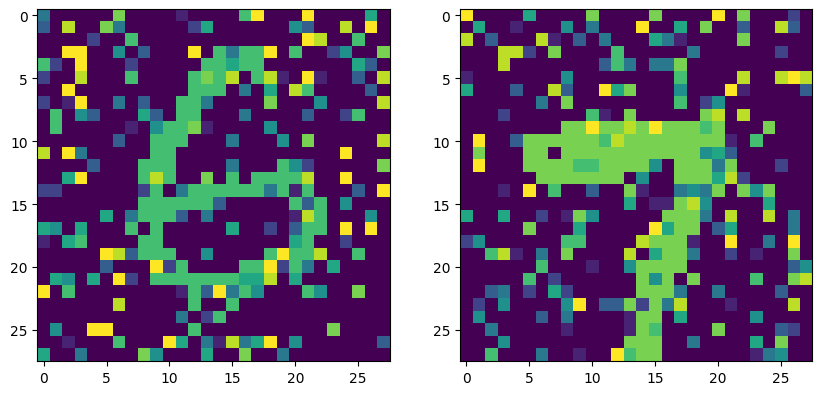

In [9]:
# Test the noise of the scheduler

sampleImages, sampleLabels = next(iter(trainDataloader))

testImage = scheduler.addNoise(sampleImages[0:2], 60)


fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(torch.argmax(testImage[0], dim=0).squeeze().cpu().numpy(), vmin=0, vmax=10)
axes[1].imshow(torch.argmax(testImage[1], dim=0).squeeze().cpu().numpy(), vmin=0, vmax=10)

plt.show()

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

#Try changing class embedding to instead use one hot encoded
class ClassConditionedUnet(nn.Module):
  def __init__(self, num_classes=11, class_emb_size=4):
    super().__init__()
    
    # The embedding layer will map the class label to a vector of size class_emb_size
    self.class_emb = nn.Embedding(num_classes, class_emb_size)


    self.guidance_prob=0.1

    # Self.model is an unconditional UNet with extra input channels to accept the conditioning information (the class embedding)
    self.model = UNet2DModel(
        sample_size=28,           # the target image resolution
        in_channels=11 + class_emb_size, # Additional input channels for class cond.
        out_channels=11,           # the number of output channels
        layers_per_block=2,       # how many ResNet layers to use per UNet block
        block_out_channels=(64, 64, 64), 
        down_block_types=( 
            "DownBlock2D",        # a regular ResNet downsampling block
            "DownBlock2D",    # a ResNet downsampling block with spatial self-attention
            "AttnDownBlock2D",
        ), 
        up_block_types=(
            "AttnUpBlock2D", 
            "UpBlock2D",      # a ResNet upsampling block with spatial self-attention
            "UpBlock2D",          # a regular ResNet upsampling block
          ),
    )

  # Our forward method now takes the class labels as an additional argument
  def forward(self, x, t, class_labels):
    # Shape of x:
    bs, ch, w, h = x.shape
    
    # class conditioning in right shape to add as additional input channels
    class_cond = self.class_emb(class_labels) # Map to embedding dimension
    batch_size, embed_dim = class_cond.shape
    mask = torch.rand(batch_size, device=class_cond.device) < self.guidance_prob
    class_cond[mask] = torch.zeros(embed_dim, device=class_cond.device)
    class_cond = class_cond.view(bs, class_cond.shape[1], 1, 1).expand(bs, class_cond.shape[1], w, h)
    # x is shape (bs, 1, 28, 28) and class_cond is now (bs, 4, 28, 28)
    
    # Net input is now x and class cond concatenated together along dimension 1
    net_input = torch.cat((x, class_cond), 1) # (bs, 5, 28, 28)

    # Feed this to the UNet alongside the timestep and return the prediction
    return self.model(net_input, t).sample # (bs, 11, 28, 28)
  
model = ClassConditionedUnet().to(device)

Using device: cuda


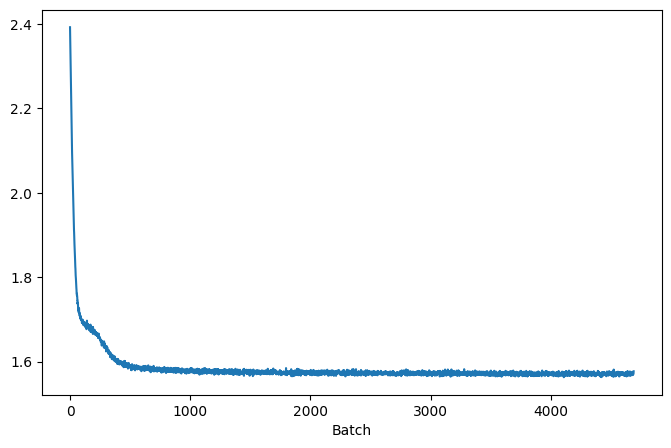

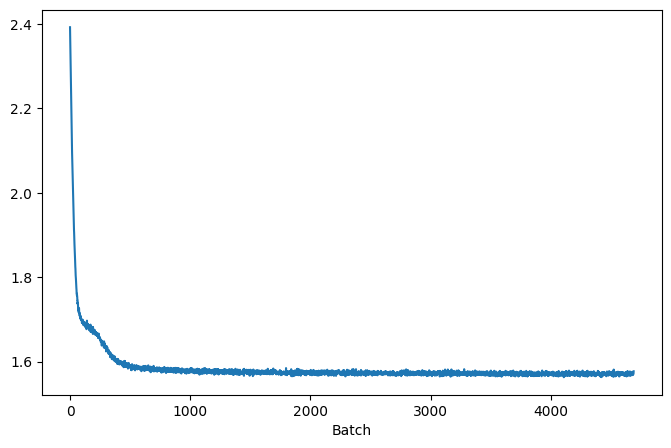

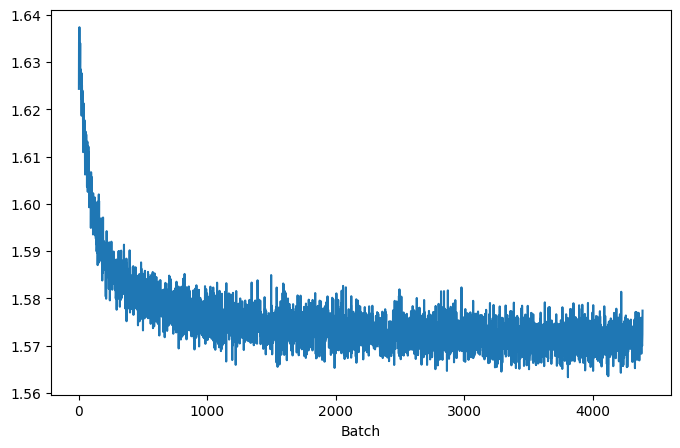

In [18]:
PLOTUPDATES = True
updateRate = 1
n_epochs = 10

opt = torch.optim.Adam(model.parameters(), lr=1e-4) 

loss_fn = nn.CrossEntropyLoss() #nn.MSELoss(reduction='sum')
losses = []

if PLOTUPDATES:
    fig, ax = plt.subplots(figsize=(8, 5))

for epoch in range(n_epochs):
    opt.zero_grad()
    for batch, labels in tqdm(trainDataloader):

        timesteps = torch.randint(0, scheduler.TrainSteps - 1, (batch.shape[0],), device='cpu').long()
        noisyImgs = scheduler.addNoise(batch, timesteps)
        

        pred = model(noisyImgs.to(device), timesteps.to(device), labels.to(device))
        pred = F.softmax(pred, dim=1) # Do i round the values?

        loss = loss_fn(pred, batch.to(device).argmax(axis=1)) 

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(loss.item())

    if PLOTUPDATES:
        if epoch % updateRate == 0:
            clear_output(wait=True)  
            ax.clear()
            plt.plot(losses)
            plt.xlabel('Batch')
            display(fig)
            
fig, ax = plt.subplots(figsize=(8, 5))
plt.plot(losses[300:])
plt.xlabel('Batch')
plt.show()

100%|██████████| 160/160 [00:01<00:00, 120.46it/s]


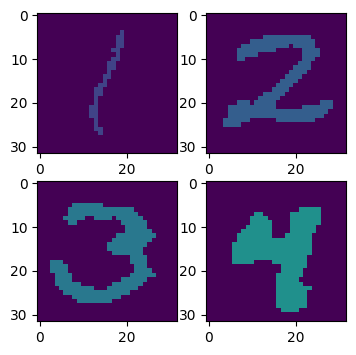

In [26]:
x = torch.randint(0, 12, (4, 11, 32, 32), device='cpu').float()
labels = torch.tensor([1, 2, 3, 4], device=device)
inferenceSteps = torch.linspace(scheduler.TrainSteps-1, 1, scheduler.TrainSteps, device='cpu').long()

y_uncond = torch.zeros_like(labels) # unconditional samples
guidance_scale = 1.0

#timesteps = torch.randint(0, scheduler.TrainSteps - 1, (batch.shape[0],), device='cpu').long()

for t in tqdm(inferenceSteps):
    with torch.no_grad():
        #residual_uncond = model(x.to(device), t, y_uncond)  # Without conditioning
        residual_cond = model(x.to(device), t, labels)           # With conditioning
        
        # Apply CFG: interpolate between uncond & cond
        #residual = residual_uncond + guidance_scale * (residual_cond - residual_uncond)
        #residual = F.softmax(residual, dim=1)
        residual = F.softmax(residual_cond, dim=1)
    x = scheduler.addNoise(residual.to('cpu'), t - 1).float()
x = F.softmax(model(x.to(device), 0, labels), dim=1)


argmax_images = torch.argmax(x, dim=1, keepdim=True)

# Show the results
fig, axs = plt.subplots(2, 2, figsize=(4, 4))
axs[0, 0].imshow(argmax_images[0, 0].cpu(), vmin=0, vmax=10)
axs[0, 1].imshow(argmax_images[1, 0].cpu(), vmin=0, vmax=10)
axs[1, 0].imshow(argmax_images[2, 0].cpu(), vmin=0, vmax=10)
axs[1, 1].imshow(argmax_images[3, 0].cpu(), vmin=0, vmax=10)
plt.show()

100%|██████████| 160/160 [00:03<00:00, 41.41it/s]


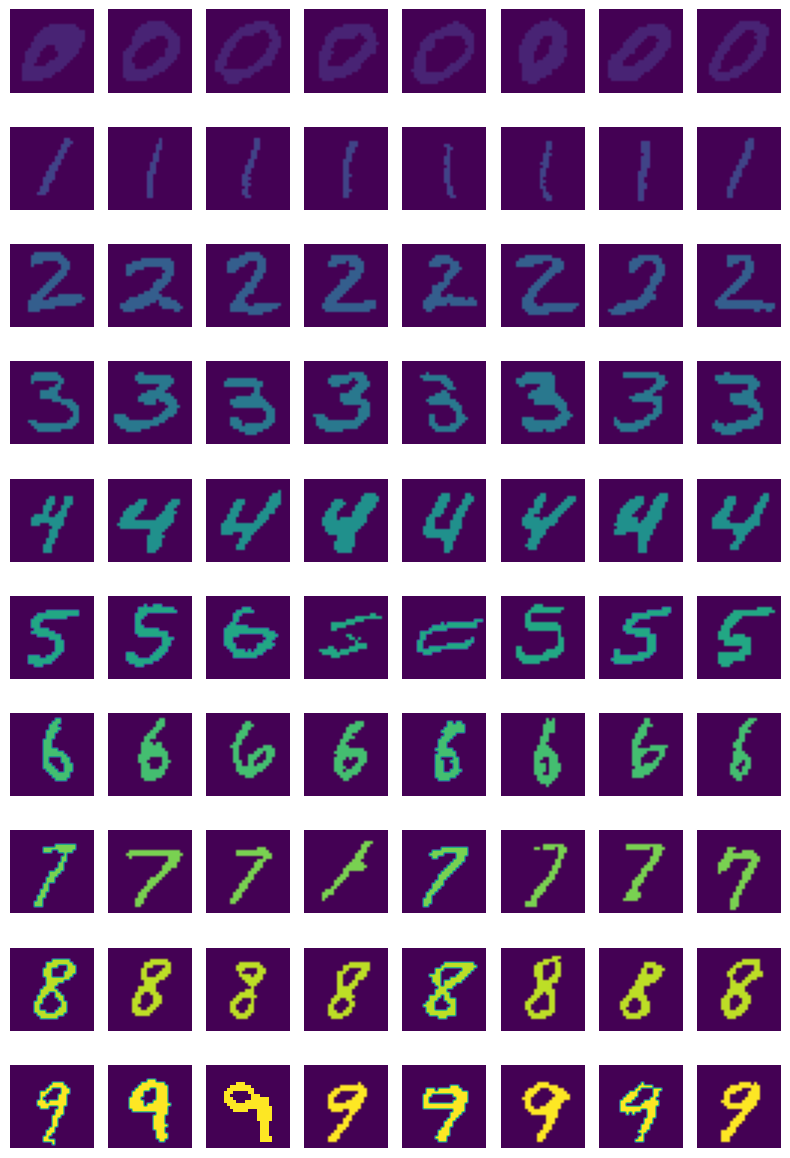

In [42]:
# Inference

model.eval()

x = torch.randint(0, 12, (80, 11, 28, 28), device=device).float()
y = torch.tensor([[i]*8 for i in range(10)]).flatten().to(device)
inferenceSteps = torch.linspace(scheduler.TrainSteps-1, 1, scheduler.TrainSteps, device=device).long()
#inferenceSteps = torch.linspace(scheduler.TrainSteps-1, 1, 5, device=device).long()

# Sampling loop
for t in tqdm(inferenceSteps):
    with torch.no_grad():
        residual_cond = model(x.to(device), t, y)
        residual = F.softmax(residual_cond, dim=1)

    x = scheduler.addNoise(residual.to('cpu'), t - 1).float()
x = F.softmax(model(x.to(device), 0, y), dim=1).float().to('cpu')

# Show the results
n_rows = 10
n_cols = 8
fig, axes = plt.subplots(n_rows, n_cols, figsize=(8, 12))
axes = axes.flatten()

newx = torch.argmax(x, dim=1)

# Loop through the images and plot them
for i in range(newx.shape[0]):
    ax = axes[i]
    ax.imshow(newx[i], vmin=0, vmax=10)
    ax.axis('off')  # Hide axes
plt.tight_layout()
plt.show()